# <span id="toc">  Esercitazione 4 - Molecular Dynamics - NVE </span>

[  Ensemble microcanonico NVE ](#ex-4.0)

[  4.1 - Calcolo della pressione ](#ex-4.1)

[  4.2 - Simulazioni con modello di Lennard-Jones  ](#ex-4.2)

&nbsp;&nbsp;  [   Equilibrazione  ](#ex-4.2.0)

&nbsp;&nbsp;  [   4.2.1 - Fase solida  ](#ex-4.2.1)

&nbsp;&nbsp;  [   4.2.2 - Fase liquida  ](#ex-4.2.2)
    
&nbsp;&nbsp;  [   4.2.3 - Fase gassosa  ](#ex-4.2.3)

## <span id="ex-4.0">  Ensemble microcanonico (NVE) </span>[^](#toc)

In generale un *ensemble statistico* è l'**insieme di tutti i possibili (micro)stati di un sistema fisico**.
In questa esercitazione devo eseguire simulazioni su un **ensemble microcanonico**, in stato solido, liquido e gassoso, a rispettive diverse temperature. 

Dal punto di vista macroscopico questo ensemble rappresenta i possibili stati di un sistema la cui **energia totale $E$ è fissata**, il quale perciò deve essere (chiuso e) isolato: da qui il nome NVE, a indicare che numero di particelle, volume ed energia sono costanti. Dal punto di vista microscopico l'ensemble microcanonico è invece definito dal postulato di **equiprobabilità**, che permette di assegnare ad ogni microstato con energia prossima ad $E$ la medesima probabilità di essere visitato.

Le proprietà termodinamiche di un microstato possono essere misurate esattamente solo se la sua configurazione nello spazio delle fasi è nota: questa conoscenza non è ovviamente possibile nella realtà, mentre lo è a livello computazionale. In questa esercitazione andrò a misurare le principali proprietà termodinamiche del sistema studiato.


## Altre premesse

Per l'esercitazione ci è stato fornito un codice procedurale già funzionante in grado di simulare l'evoluzione dinamica di un sistema di $N= 108$ particelle tramite l'algoritmo di Verlet, e di misurarne energia totale per particella $E/N$, energia potenziale per particella $U/N$, energia cinetica per particella $K/N$ e temperatura $T$. Il programma può inoltre salvare le posizioni delle molecole nello spazio 3D, utile per visualizzare il moto del sistema tramite software appositi come Ovito. Tale visualizzazione rende particolarmente evidente il significato di *Periodic Boundary Conditions*, per chi ci fosse poco abituato.

Densità $\rho$ (da cui dipendono volume `vol` e dimensioni lineari `box` del sistema), raggio di cutoff `rcut`, passo `delta`, temperatura `temp`, sono altri parametri regolabili dai file di input che modificano le proprietà del sistema e le caratteristiche della simulazione.

In particolare:
- **raggio di cutoff**: distanza oltre la quale approssimiamo nulla l'interazione tra coppie di particelle (vedi [⚠️ tail corrections, esercitazione 7](../07-ok/my-07.ipynb))
- **delta**: passo dell'algoritmo di Verlet
- **temperatura**: temperatura indicata per la fase di [equilibrazione](#ex-4.2.0), utilizzata per inizializzare le velocità delle particelle a partire da una configurazione le cui velocità NON sono note (i.e. durante la primissima simulazione)

#### Periodic Boundary Conditions

Una simulazione di Dinamica Molecolare si pone l'obiettivo di *simulare il moto delle particelle del sistema*, in linea di principio risolvendo le equazioni del moto. Tipicamente in un sistema termodinamico di $\sim10^{23}$ particelle questo non è fattibile in tempi sensati. Supponiamo allora che il nostro sistema abbia proprietà geometriche periodiche, e per la simulazione ne consideriamo solo la cella elementare di lato `box` (dal punto di vista del codice il processo è inverso: considero $N$ particelle in un cubo e applicando le PBC mando a $+\infty$ il sistema): ogni volta che una particella esce dalla cella, essa viene "reimmessa" dal lato opposto. Si noti che le PBC fanno anche in modo che durante la simulazione venga sempre considerata la **distanza minima** fra le (infinite) immagini di due particelle.

#### Algoritmo di Verlet

L'algoritmo di Verlet si usa per integrare le equazioni del moto di Newton. Esso valuta la posizione successiva considerando quella presente e quella precedente:
$$
\vec r(t+\delta t) \approx 2\vec r(t) -\vec r(t-\delta t) + \delta t^2 \vec a(t)
$$
dove $\vec a$ è l'accelerazione. Per costruzione questo algoritmo non può partire conoscendo solo lo stato iniziale $[\vec r(0), \vec v(0)]$. Per questo motivo nella parte di inizializzazione del sistema nel codice fornitoci è implementato un algoritmo leggermente diverso, che estrapola la posizione precedente come $\vec r_{new} = \vec r - \vec v \cdot \delta t$, dove posizioni e velocità sono lette dai file `config.out` e `velocity.out` generati in uscita da una precedente simulazione (tutto questo quando si pone `restart=1` tra i parametri di input). Questo procedimento pone però un problema al momento della prima inizializzazione, come spiego meglio [dopo](#ex-4.2.0).

L'algoritmo di Verlet soddisfa le principali proprietà richieste agli algoritmi della sua classe:
- conserva energia e momento
- è time-reversible 
- è efficiente
- permette di usare $\delta t$ grandi conservando comuque bene l'energia

## <span id="ex-4.1">  Esercizio 4.1 </span>[^](#toc)



La prima richiesta agli studenti è stata di aggiungere al codice le necessarie funzionalità per il calcolo della pressione $P$, in forma di medie di blocco, medie progressive e incertezze progressive. Per fare ciò, è innanzitutto necessario ricordare che, dal **teorema del viriale**, la pressione in un sistema con potenziale di Lennard-Jones vale:
$$
P = \rho k_B T + \frac{1}{3V} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48\epsilon \left[ \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - 
\frac{1}{2} \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] \right\rangle
$$
con l'accortezza di considerare nel codice le unità di misura ridotte $ V= \epsilon V^* , E= \epsilon E^*, K= \epsilon K^*, T = \frac{\epsilon}{k_B}T^*, P = \frac{\epsilon}{\sigma^3} P^*$ (nota: $\langle ... \rangle$ indica media di ensemble). In tal caso tutte le grandezze sono di ordine $1$ e la legge si semplifica:
$$
P^* = \rho^* T^* + 
                \frac{1}{3V^*}
                \left\langle
                    \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 
                        48 \left[   
                            \left(
                                \frac{1}{|\vec{r}_i -\vec{r}_j|}
                            \right)^{12} 
                            -\frac{1}{2}
                            \left(
                                \frac{1}{|\vec{r}_i -\vec{r}_j|}
                            \right)^6 
                           \right] 
                \right\rangle
    = \rho^* T^* + 
                \frac{
                \left\langle
                    W 
                \right\rangle
                }{3V^*}
$$


Per farlo ho dovuto aggiungere un accumulatore per il viriale $\langle W \rangle$, a cui sommare solo quando la distanza `dr` tra due particelle risultava inferiore a `rcut`:
```c++
w += 48.0/pow(dr,12) - 24.0/pow(dr,6); // Viriale
```
da cui la pressione è calcolata come:
```c++
rho*walker[it]+w/(3.0*vol);  // Pressione
```
dove `walker[it]` è la temperatura. Per il resto, la pressione è stata trattata in modo perfettamente analogo alle altre variabili.

## <span id="ex-4.2.0">  Equilibrazione </span>[^](#toc)

Come anticipato, al momento della prima inizializzazione si pone un problema: possiamo scegliere come configurazione quella di un cristallo, ma come velocità? La scelta più semplice è generarle casualmente secondo la distribuzione di Maxwell-Boltzmann.
Questo viene fatto quando tra i parametri di input si pone `restart=0`: il programma carica la configurazione cristallina salvata in `input/config.in` ed estrae le velocità secondo la distribuzione di Maxwell-Boltzmann (e correggendo un effetto di drift indesiderato).  
Tuttavia, anche questa inizializzazione non garantisce un perfetto equilibrio al sistema: la temperatura infatti non si mantiene al valore richiesto ma tende a derivare verso un altro valore, attorno al quale poi si stabilizza.

Questo è dovuto al fatto che il codice estrae le probabilità secondo una Maxwelliana, ma successivamente le collisioni redistribuiscono l'energia cinetica diversamente. In effetti, per definizione nell'ensemble microcanonico la temperatura non è fissata.

Modificando la temperatura iniziale in modo che il valore di stabilizzazione sia quello desiderato è comuque possibile salvare posizioni e velocità, da dare poi in ingresso alle simulazioni vere e proprie.

Ho quindi monitorato i valori di temperatura istantanei per ogni step (usando $2\times 10^4$ blocchi da $1$ step per le fasi solida e liquida e $4\times 10^4$ blocchi per la fase gassosa, più lenta a raggiungere l'equilibrio, a causa delle più rare interazioni tra le particelle). Alla fine dell'equilibrazione sposto i file con le configurazioni (che verranno letti per le simulazioni vere e proprie) e quello con l'andamento della temperatura nella cartella `eq` invocando `./cp_post_eq.sh`.
I valori che ho individuato in questo modo sono:
- $T_{in,s} = 1.541$, per la fase **solida** ($T_{target,s} = 0.8$)
- $T_{in,l} = 1.99$, per la fase **liquida** ($T_{target,l} = 1.1$)
- $T_{in,g} = 0.96$, per la fase **gassosa** ($T_{target,g} = 1.2$)

L'intero set di parametri utilizzati (in unità di Lennard-Jones) è lo stesso delle simulazioni successive:
1. fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off: $r_c = 2.2$)
2. fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off: $r_c = 2.5$)
3. fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c = 5.0$)

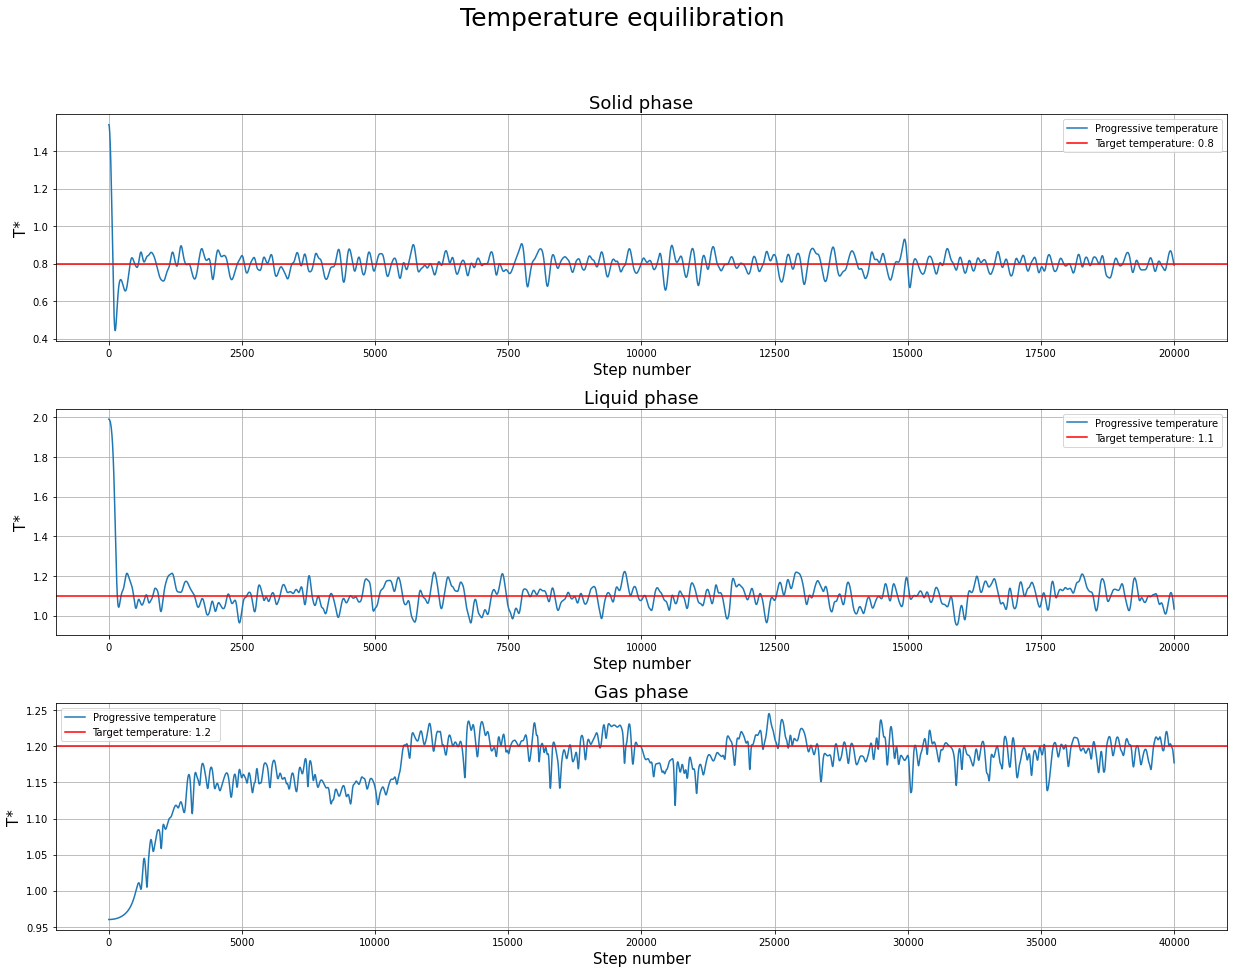

In [2]:
# NOTA: il gas è più lento ad equilibrarsi, perciò uso il doppio dei punti

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

npart = 108

N = [20000,20000,40000]

phases = ["solid", "liquid", "gas"]
titles = ["Solid phase", "Liquid phase", "Gas phase"]
Teq = [0.8, 1.1, 1.2]

plt.figure(figsize=(21,15))
plt.suptitle("Temperature equilibration", fontsize = 25)

for i in range(0,3):

    plt.subplot(3,1,i+1)
    x = np.arange(N[i])+1    # uso l'ordinamento da 1 a N

    aveT = np.loadtxt("ex4-MD_NVE/output/"+phases[i]+"/eq/output_temp.dat", usecols=(2), delimiter=' ', unpack='true')
    plt.plot(x, aveT, marker=None, label="Progressive temperature")
    plt.title(titles[i], fontsize = 18)
    plt.ylabel('T*', fontsize = 15)
    plt.xlabel('Step number', fontsize = 15)
    plt.axhline(y=Teq[i], color ="r", label = "Target temperature: "+str(Teq[i]))
    plt.grid(True)
    plt.legend()
    plt.subplots_adjust(hspace=0.3)
plt.show()


### Osservazioni

L'equilibrazione risulta efficace per tutte e tre le fasi, benché gli step necessari per raggiungere la stabilità siano molto maggiori per la fase gassosa (tra 1 e 2 ordini di grandezza): questo è coerente con il fatto che le densità sono diverse (di poco più di 1 ordine di grandezza), e da esse dipende direttamente da frequenza degli urti che permettono alle particelle di redistribuire l'energia cinetica.

Si osserva inoltre che il sistema gassoso può subire ampie oscillazioni (es: tra gli step $20000$ e $25000$) da cui recupera l'equilibrio lentamente. Questo può essere dovuto ad una ancora inprecisa equilibrazione o a scostamenti casuali dall'equilibrio, mentre la lentezza di recupero si può giustificare come l'osservazione precedente.


## <span id="ex-4.2">  Esercizio 4.2 </span>[^](#toc)

Con il codice aggiornato ho proceduto con le simulazioni del sistema termodinamico (con potenziale di Lennard-Jones per l'Argon: $\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) nelle condizioni che ho anticipato prima.

Di seguito sono riportati i grafici (in unità di misura ridotte) che mostrano le medie progressive con rispettive incertezze in funzione del numero di blocchi per:
- energia cinetica per particella, $K^*/N$
- energia potenziale per particella, $U^*/N$
- energia interna totale per particella, $E^*/N$
- pressione, $P^*$
- temperatura, $T^*$

con $50$ blocchi da $2000$ step ciascuno.
Della temperatura ho riportato anche ciascuna media di blocco, in modo da verificare a occhio che venisse conservata l'equilibrazione fatta in precedenza.


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

npart = 108

N = 50
x = np.arange(N)+1    # uso l'ordinamento da 1 a N

th_var = ["ekin", "epot", "etot", "pres", "temp"]
labels = [  "Kinetic en.\n(progr. average)",
            "Potential en.\n(progr. average)",
            "Total en.\n(progr. average)",
            "Pressure\n(progr. average)", 
            "Temperature\n(block average)",
            "Temperature\n(progr. average)"]
titles = [  "Kinetic energy",
            "Potential energy",
            "Total energy",
            "Pressure", 
            "Temperature",
            "Temperature"]
ylabels = ["K*/N", "U*/N", "E*/N", "p*", "T*", "T*"]
colors = ["r", "g", "b", "k", "c"]

### <span id="ex-4.2.1">  Esercizio 4.2.1 - Fase solida </span>[^](#toc)


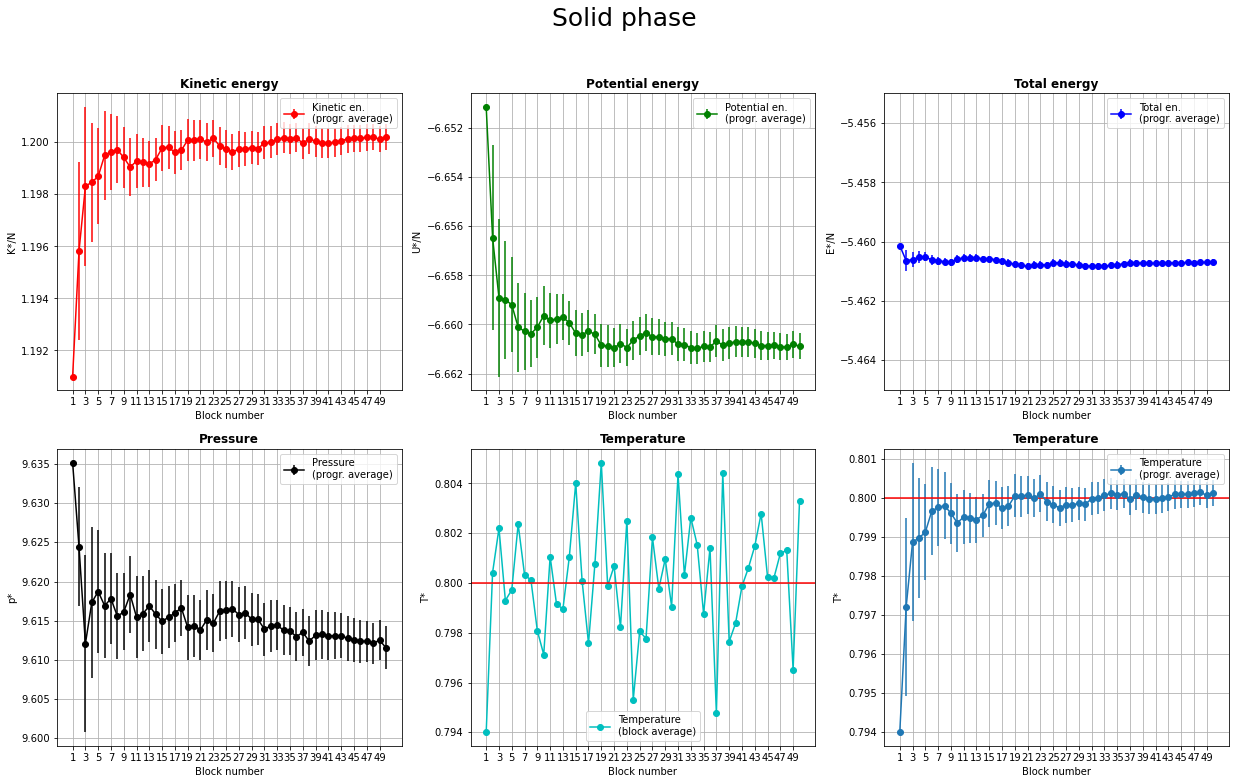

In [4]:
#solid
plt.figure(figsize=(21,12))
plt.suptitle("Solid phase", fontsize = 25)

for i in range(0,5):
    
    plt.subplot(2,3,i+1)
    ave, ave_prog, err = np.loadtxt("ex4-MD_NVE/output/solid/output_"+th_var[i]+".dat", usecols=(2,3,4), delimiter=' ', unpack='true')

    if(i!=4):
        plt.errorbar(x, ave_prog, yerr = err, marker='o', label=labels[i], color = colors[i])
    if(i==4):
        plt.plot(x, ave, marker='o', label=labels[i], color = colors[i])
    plt.title(titles[i], fontweight='bold')
    plt.ylabel(ylabels[i])
    plt.xlabel('Block number')
    plt.xticks(np.arange(1,N+1,2))
    if(i==2):
        plt.ylim(-5.465, -5.455) # si nota che nella scala delle variazioni di K e U, l'energia totale resta fissata: Compatibile con NVE!
    if(i==4):
        plt.axhline(y=0.8, color ="r") # desired equilibrium T*
    plt.grid(True)
    plt.legend()

i=5
plt.subplot(2,3,i+1)
plt.errorbar(x, ave_prog, yerr = err, marker='o', label=labels[i])
plt.title(titles[i], fontweight='bold')
plt.ylabel(ylabels[i])
plt.xlabel('Block number')
plt.xticks(np.arange(1,N+1,2))
plt.axhline(y=0.8, color ="r") # desired equilibrium T*
plt.grid(True)
plt.legend()
plt.show()

plt.show()


**Nota**: nel terzo grafico (energia totale) ho scelto di impostare i limiti delle ordinate in modo che la scala fosse simile a quella delle altre energie, in modo da mettere in evidenza il fatto che quest'ultima risulta praticamente costante rispetto alle altre, coerentemente con la definizione macroscopica di ensemble microcanonico.



### <span id="ex-4.2.2">  Esercizio 4.2.2 - Fase liquida </span>[^](#toc)


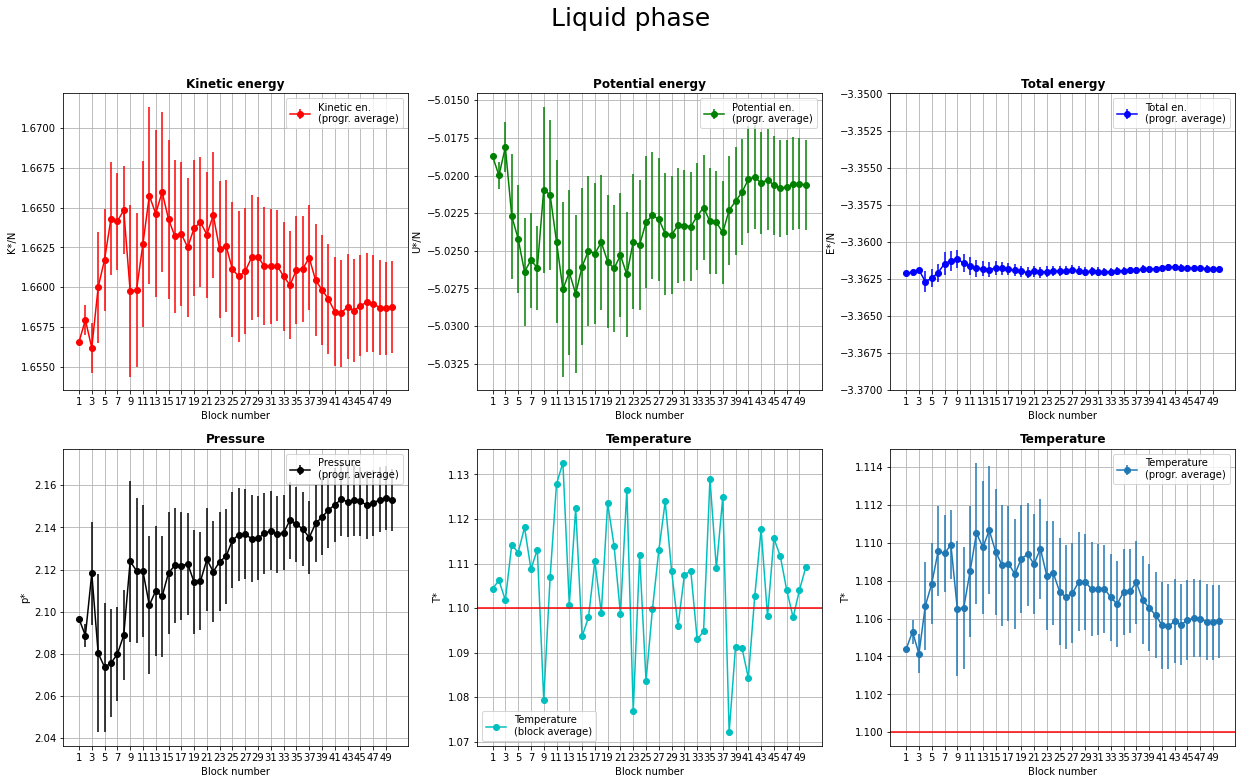

In [5]:
#liquid

plt.figure(figsize=(21,12))
plt.suptitle("Liquid phase", fontsize = 25)

for i in range(0,5):
    
    plt.subplot(2,3,i+1)
    ave, ave_prog, err = np.loadtxt("ex4-MD_NVE/output/liquid/output_"+th_var[i]+".dat", usecols=(2,3,4), delimiter=' ', unpack='true')

    if(i!=4):
        plt.errorbar(x, ave_prog, yerr = err, marker='o', label=labels[i], color = colors[i])
    if(i==4):
        plt.plot(x, ave, marker='o', label=labels[i], color = colors[i])
    plt.title(titles[i], fontweight='bold')
    plt.ylabel(ylabels[i])
    plt.xlabel('Block number')
    plt.xticks(np.arange(1,N+1,2))
    if(i==2):
        plt.ylim(-3.37, -3.35) # si nota che nella scala delle variazioni di K e U, l'energia totale resta fissata: Compatibile con NVE!
    if(i==4):
        plt.axhline(y=1.1, color ="r") # desired equilibrium T*
    plt.grid(True)
    plt.legend()

i=5
plt.subplot(2,3,i+1)
plt.errorbar(x, ave_prog, yerr = err, marker='o', label=labels[i])
plt.title(titles[i], fontweight='bold')
plt.ylabel(ylabels[i])
plt.xlabel('Block number')
plt.xticks(np.arange(1,N+1,2))
plt.axhline(y=1.1, color ="r") # desired equilibrium T*
plt.grid(True)
plt.legend()
plt.show()

plt.show()

**Nota**: come sopra, nel terzo grafico (energia totale) ho scelto di impostare i limiti delle ordinate in modo che la scala fosse simile a quella delle altre energie, in modo da mettere in evidenza il fatto che quest'ultima risulta praticamente costante rispetto alle altre, coerentemente con la definizione macroscopica di ensemble microcanonico.

Osservo inoltre che la temperatura rimane leggermente al di sopra del valore target ($<1\%$): questo potrebbe essere interpretato in due modi
1. anche dopo l'equilibrazione il sistema va incontro a oscillazioni casuali che non sono sotto il mio controllo
2. l'equilibrazione non è perfetta

Ritengo più probabile la seconda perché l'equilibrazione è stata effettuata su $20000$ step, mentre la simulazione ne copre $50\times2000=10^5$, quindi ogni oscillazione casuale particolarmente ampia fuori dall'equilibrio avrebbe fatto abbondantemente in tempo ad essere riassorbita (come abbiamo visto, per le fasi solida e liquida sono sufficienti qualche $10^2$ step per raggiungere la stabilità).

### <span id="ex-4.2.3">  Esercizio 4.2.3 - Fase gassosa </span>[^](#toc)


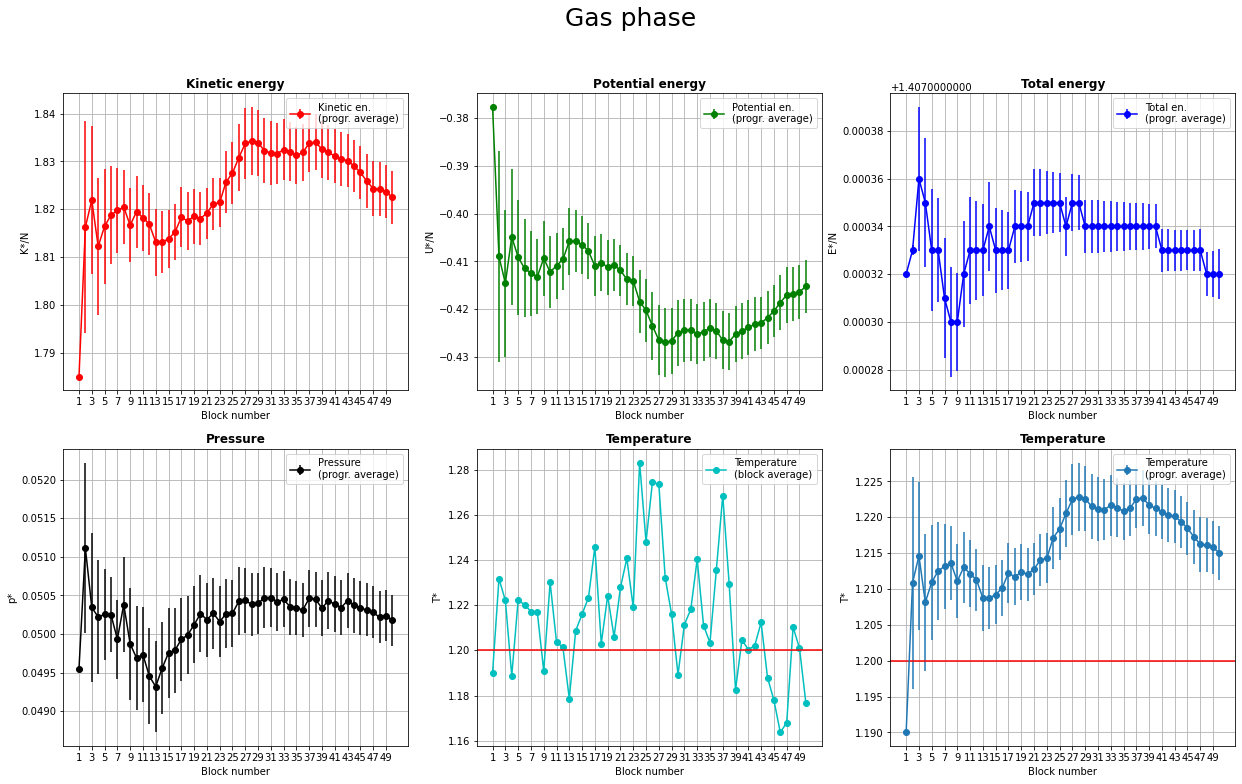

In [6]:
#gas

plt.figure(figsize=(21,12))
plt.suptitle("Gas phase", fontsize = 25)

for i in range(0,5):
    
    plt.subplot(2,3,i+1)
    ave, ave_prog, err = np.loadtxt("ex4-MD_NVE/output/gas/output_"+th_var[i]+".dat", usecols=(2,3,4), delimiter=' ', unpack='true')

    if(i!=4):
        plt.errorbar(x, ave_prog, yerr = err, marker='o', label=labels[i], color = colors[i])
    if(i==4):
        plt.plot(x, ave, marker='o', label=labels[i], color = colors[i])
    plt.title(titles[i], fontweight='bold')
    plt.ylabel(ylabels[i])
    plt.xlabel('Block number')
    plt.xticks(np.arange(1,N+1,2))
    #if(i==2):
    #    plt.ylim(1.377,1.437) # si nota che nella scala delle variazioni di K e U, l'energia totale resta fissata: Compatibile con NVE!
    if(i==4):
        plt.axhline(y=1.2, color ="r") # desired equilibrium T*
    plt.grid(True)
    plt.legend()

i=5
plt.subplot(2,3,i+1)
plt.errorbar(x, ave_prog, yerr = err, marker='o', label=labels[i])
plt.title(titles[i], fontweight='bold')
plt.ylabel(ylabels[i])
plt.xlabel('Block number')
plt.xticks(np.arange(1,N+1,2))
plt.axhline(y=1.2, color ="r") # desired equilibrium T*
plt.grid(True)
plt.legend()
plt.show()

plt.show()

**Nota**: diversamente da prima, nel terzo grafico (energia totale) ho lasciato libera la scala delle ordinate, altrimenti sarebbe stato impossibile apprezzare gli errori. Si osserva comunque che l'energia totale è molto più stabile delle altre (oscillazioni 3 ordini di grandezza inferiori), sempre coerentemente col fatto che l'ensemble è microcanonico.

Osservo inoltre come prima che la temperatura rimane leggermente al di sopra del valore target ($\sim1\%$): in questo caso però tra le due ipotesi considero ragionevole anche la prima, visto l'andamento della media progressiva e date le osservazioni sulla lentezza del sistema gassoso nel redistribuire l'energia (quindi rispondere alle deviazioni di temperatura).

Osservo il curioso andamento dell'energia totale. Avendo escluso errori di arrotondamento poiché siamo lontani dal limite di rappresentazione dei numeri `double` in memoria ho guardato il file in cui sono salvati i dati: sono salvati con 6 cifre significative, per impostazione automatica dello stream. Ho scelto di non ripetere la simulazione, dal momento che per i miei scopi l'attuale risultato è comunque sufficiente.

### Osservazioni generali

Osservo che in tutti e tre i casi le pressioni scalano come le rispettive densità, ragionevolmente.

Inoltre, si vede che le energie totali dei tre sistemi sono $E_s<E_l<E_g$, a causa dei diversi contributi dell'energia potenziale (anche l'energia cinetica cambia, essendo maggiore per la fase gassosa, ma meno): è comprensibile che i sistemi a densità maggiore risentano maggiormente del contributo attrattivo del potenziale che ne abbassa l'energia.

In tutti e tre i casi infine, osservo che temperatura ed energia cinetica sono proporzionali tra loro, coerentemente con le rispettive definizioni, mentre la pressione risulta avere un andamento intermedio tra energia potenziale e temperatura, coerentemente con la legge che la definisce.